# Hyperparameters tuning by grid search
In this example we will demonstrate how to perform grid search on the coreset tree. 

The results are compared with those obtained using GridSearchCV class from scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

For the experiments, Covertype Data Set is used (http://archive.ics.uci.edu/ml/datasets/covertype) 

Note that the notebook may take a long time to run (e.g., 40-60 minutes). Running grid search on the full dataset takes most of the notebook’s time. On the coreset in runs in a few minutes.

In [20]:
import itertools
import collections
import io
import re
import warnings
import numpy as np
from time import time
from contextlib import redirect_stdout
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import balanced_accuracy_score, make_scorer
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from dataheroes import CoresetTreeServiceDTC
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

### Prepare the datasets

In [21]:
X, y = fetch_covtype(return_X_y=True)
# Label-Encode the target. We do so because, further down the road, we will use XGBoost for
# modeling, which requires consecutive integer labels starting from 0
label_enc = LabelEncoder()
y = label_enc.fit_transform(y)
# Apply standard scaling on the X
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Split into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
print(f"#classes={len(np.unique(y))}, train dataset size={len(X_train):,}, test dataset size={len(X_test):,}")

#classes=7, train dataset size=406,708, test dataset size=174,304


###  Build the tree
Initialize the service and build the tree.

The tree uses the local file system to store its data.

After this step you will have a new directory .dataheroes_cache.

In [22]:
n_instances = len(X_train)
start = time()
# In order to be able to perform grid search, chunk_sample_ratio must be greater than 0.0
service_obj = CoresetTreeServiceDTC(
    optimized_for='training',
    chunk_size=40000,
    coreset_size=15000
)
service_obj.build(X_train, y_train)
end = time()
coreset_build_time = end - start
print(f"CoresetTreeServiceDTC construction lasted {coreset_build_time:.2f} seconds")

CoresetTreeServiceDTC construction lasted 4.10 seconds


### Plot the tree

{'training': WindowsPath('training_tree_20230721_084934.png')}

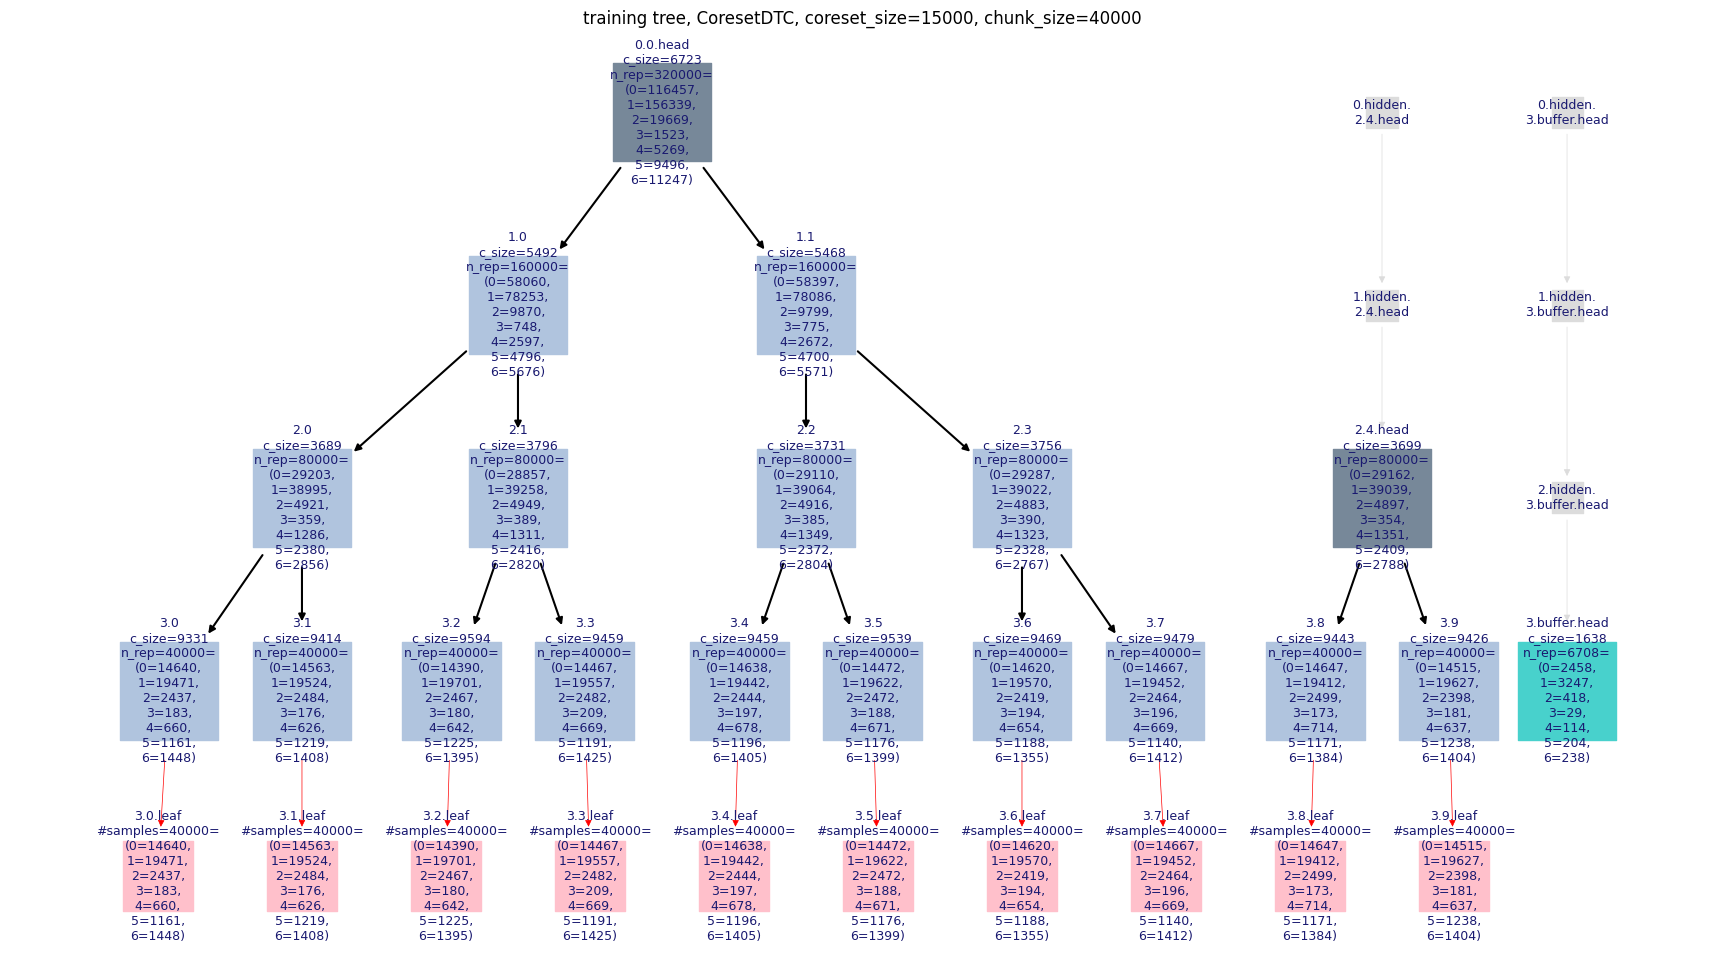

In [23]:
service_obj.plot()

### Define the hyperparameters grid and the scoring function

In [24]:
param_grid = {'lambda':[10, 100], 'max_depth':[3, 6]}
balanced_accuracy_scoring = make_scorer(balanced_accuracy_score)
# The following line is only useful for this demo in order to ensure the results are aligned
param_grid = collections.OrderedDict(sorted(param_grid.items()))

### Perform grid search on the coreset tree

In [25]:
with redirect_stdout(io.StringIO()) as f_coreset:
    start = time()
    optimal_hyperparameters, trained_model = service_obj.grid_search(param_grid=param_grid, scoring=balanced_accuracy_scoring, verbose=2)
    end = time()
    coreset_grid_search_time = end - start
    y_pred = trained_model.predict(X_test)
    coreset_best_params_test_score = balanced_accuracy_score(y_test, y_pred)
    print(f'\nThe balanced accuracy score for the best hyperparameters is: {coreset_best_params_test_score}')
    print(f'The optimal hyperparameters are: {optimal_hyperparameters}')
    print(f"Grid search on the corset tree lasted {coreset_grid_search_time:.2f} seconds")

### Parse the output to get the scores 

Note that this is a step useful only for the demo

In [26]:
def parse_coreset_grid_search_output(str_output):
    params_combination_output = str_output.split('Start cross-validation with parameters:')
    hyperparams_combinations_averages = []
    for output in params_combination_output:
        x = re.findall("The score for the fold \d was .+", output)
        if len(x) > 0:
            hyperparams_average = 0
            for match in x:
                score = float(match.split()[-1][:-1])
                hyperparams_average += score
            hyperparams_average /= float(len(x))
            hyperparams_combinations_averages.append(hyperparams_average)
    return hyperparams_combinations_averages
str_output = f_coreset.getvalue()
validation_scores_coreset = parse_coreset_grid_search_output(str_output)


### Perform grid search with a random sample
The random sample has the same size as the coreset 

The hyperparameters grid is the same

In [27]:
cv = 5
with redirect_stdout(io.StringIO()) as f_random:    
    model = XGBClassifier()
    # Grid search was performed at the level 2 in the tree
    # We find the size of the coreset in order to generate a random sample of equal size
    coreset_obj = service_obj.get_coreset(level=2)
    coreset_X = coreset_obj['data'][1]
    coreset_size = len(coreset_X)
    idx = np.random.choice(np.arange(len(X_train)), coreset_size, replace=False)
    X_random = X_train[idx]
    y_random = y_train[idx]
    start = time()
    clf = GridSearchCV(model, param_grid, cv=cv, scoring=balanced_accuracy_scoring, verbose=3)
    trained_model = clf.fit(X_random, y_random)
    end = time()
    y_pred = trained_model.predict(X_test)
    random_sample_best_params_test_score = balanced_accuracy_score(y_test, y_pred)
    random_grid_search_time = end - start
    print(f'\nThe balanced accuracy score for the best hyperparameters is: {random_sample_best_params_test_score}')
    print(f'The optimal hyperparameters are: {clf.best_params_}')
    print(f"Grid search with the random sample lasted {random_grid_search_time:.2f} seconds")

### Parse the output to get the scores for the random sample

Note that this is a step useful only for the demo

In [28]:
def parse_standard_grid_search_output(str_output, cv):
    params_combination_output = str_output.split(f'[CV 1/{cv}]')
    hyperparams_combinations_averages = []
    for output in params_combination_output[1:]:
        x = re.findall("score=\d+\.\d+", output)
        if len(x) > 0:
            hyperparams_average = 0
            for match in x:
                score = float(match.split('=')[-1])
                hyperparams_average += score
            hyperparams_average /= float(len(x))
            hyperparams_combinations_averages.append(hyperparams_average)
    return hyperparams_combinations_averages
str_output = f_random.getvalue()
validation_scores_random = parse_standard_grid_search_output(str_output, 5)

### Perform grid search with the entire training sample
The hyperparameters grid is the same

In [29]:
with redirect_stdout(io.StringIO()) as f_full:  
    model = XGBClassifier()
    start = time()
    clf = GridSearchCV(model, param_grid, cv=cv, scoring=balanced_accuracy_scoring, verbose=3)
    trained_model = clf.fit(X_train, y_train)
    end = time()
    full_grid_search_time = end - start
    y_pred = trained_model.predict(X_test)
    full_best_params_test_score = balanced_accuracy_score(y_test, y_pred)
    print(f'\nThe balanced accuracy score for the best hyperparameters is: {full_best_params_test_score}')
    print(f'The optimal hyperparameters are: {clf.best_params_}')
    print(f"Grid search with the full training data lasted {full_grid_search_time:.2f} seconds")    

### Parse the output to get the scores for the full training dataset

Note that this is a step useful only for the demo

In [30]:
str_output = f_full.getvalue()
validation_scores_full = parse_standard_grid_search_output(str_output, cv)

### Plot the best scores

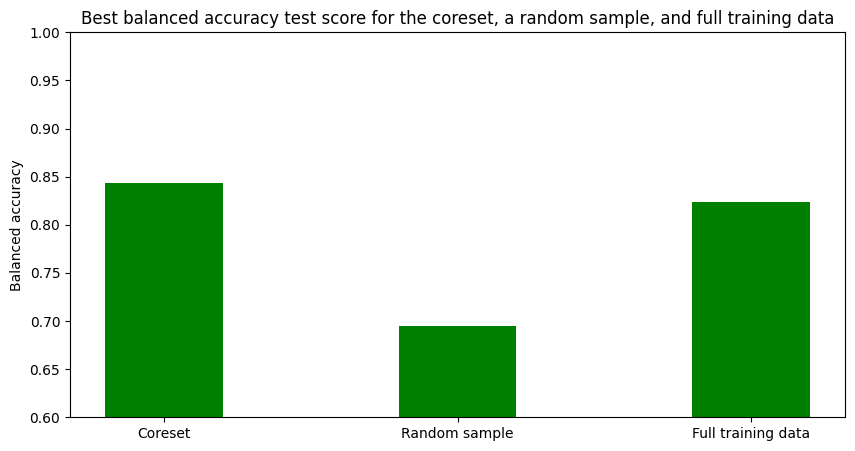

In [31]:
data = {'Coreset':coreset_best_params_test_score, 'Random sample':random_sample_best_params_test_score,
        'Full training data':full_best_params_test_score}
datasets = list(data.keys())
scores = list(data.values())

fig = plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.set_ylim([0.6, 1.0])
plt.bar(datasets, scores, color='green', width=0.4)
 
plt.ylabel("Balanced accuracy")
plt.title("Best balanced accuracy test score for the coreset, a random sample, and full training data")
plt.show()

### Plot the execution time

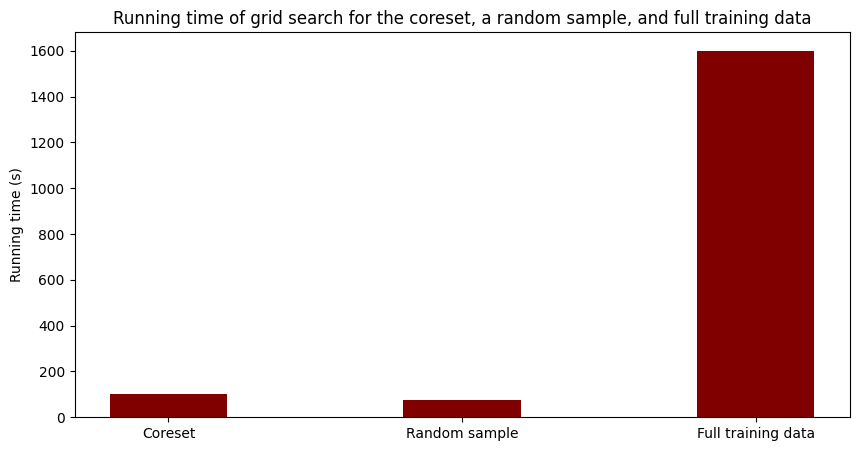

In [32]:
data = {'Coreset':coreset_grid_search_time, 'Random sample':random_grid_search_time,
        'Full training data':full_grid_search_time}
datasets = list(data.keys())
times = list(data.values())

fig = plt.figure(figsize=(10, 5))
plt.bar(datasets, times, color='maroon', width=0.4)
 
plt.ylabel("Running time (s)")
plt.title("Running time of grid search for the coreset, a random sample, and full training data")
plt.show()

### Compute test scores for every combination of hyperparameters from the grid

In [33]:
params_names = list(param_grid.keys())
params_values = param_grid.values()
params_values_combinations = itertools.product(*params_values)
test_scores_coreset = []
test_scores_random = []
test_scores_full = []
balanced_accuracy_scoring = make_scorer(balanced_accuracy_score)
for params_values_combination in params_values_combinations:
    model_params = dict(zip(params_names, params_values_combination))
    print(f'Perform training and testing with hyperparameters {model_params}')
    
    trained_model = service_obj.fit(level=2, **model_params)
    y_pred = trained_model.predict(X_test)
    score_coreset = balanced_accuracy_score(y_test, y_pred)
    test_scores_coreset.append(score_coreset)

    model = XGBClassifier(**model_params)
    model.fit(X_random, y_random)
    y_pred = model.predict(X_test)
    score_random = balanced_accuracy_score(y_test, y_pred)
    test_scores_random.append(score_random)
    
    model = XGBClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_full = balanced_accuracy_score(y_test, y_pred)
    test_scores_full.append(score_full)

Perform training and testing with hyperparameters {'lambda': 10, 'max_depth': 3}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params)
Perform training and testing with hyperparameters {'lambda': 10, 'max_depth': 6}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params)
Perform training and testing with hyperparameters {'lambda': 100, 'max_depth': 3}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params)
Perform training and testing with hyperparameters {'lambda': 100, 'max_depth': 6}
Using XGBClassifier model. To use a different model, please set the model parameter. E.g.: service_obj.fit(model=LGBMClassifier(**params), **other_params)


### Plot the validation and test scores
The validation scores were extracted from the output of the grid search methods

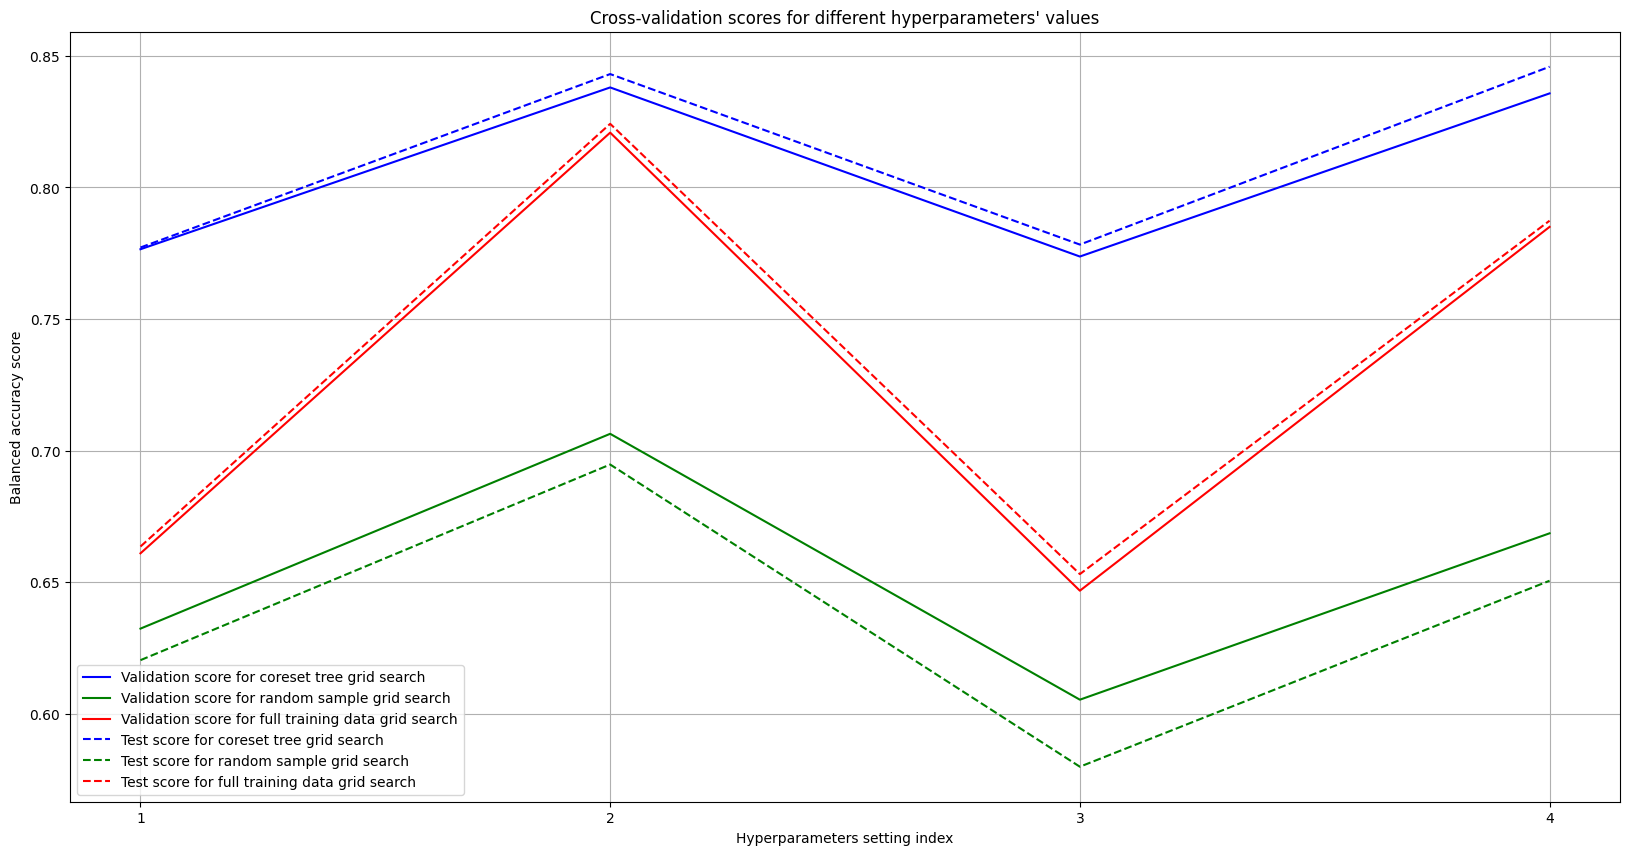

In [34]:
fig_scores, axd_scores = plt.subplots(figsize=(20, 10))

indexes = np.array(range(len(test_scores_coreset))) + 1
axd_scores.plot(indexes, validation_scores_coreset, label=f"Validation score for coreset tree grid search", color="blue")
axd_scores.plot(indexes, validation_scores_random, label=f"Validation score for random sample grid search", color="green")
axd_scores.plot(indexes, validation_scores_full, label=f"Validation score for full training data grid search", color="red")

axd_scores.plot(indexes, test_scores_coreset, label=f"Test score for coreset tree grid search", color="blue", linestyle='--')
axd_scores.plot(indexes, test_scores_random, label=f"Test score for random sample grid search", color="green", linestyle='--')
axd_scores.plot(indexes, test_scores_full, label=f"Test score for full training data grid search", color="red", linestyle='--')

axd_scores.grid(True)
axd_scores.ticklabel_format(useOffset=False)
axd_scores.set_ylabel('Balanced accuracy score')
axd_scores.set_xlabel("Hyperparameters setting index")
axd_scores.set_xticks(indexes)
axd_scores.legend()
_ = axd_scores.set_title("Cross-validation scores for different hyperparameters' values")